In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [4]:
#Carrega o dataset
df = read_csv('./data/Eletrical_Production.csv', names=['KW'], usecols=[1], header=0)
df.head(10)

,KW
0,3.3842
1,3.4100
2,3.4875
3,3.5133
4,3.5133
5,3.5650
6,3.5650
7,3.6167
8,3.7200
9,3.7200


In [19]:
X = df.values
X = X.astype('float32')
X.shape

(964, 1)

<AxesSubplot:ylabel='KW'>

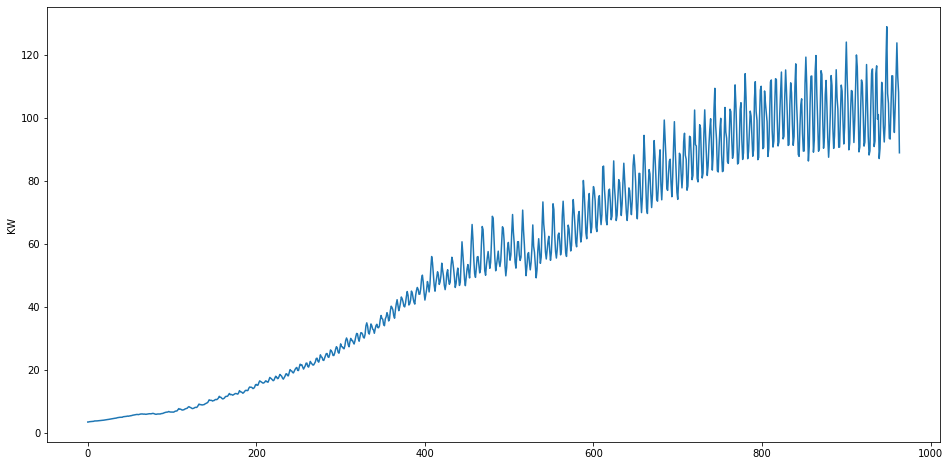

In [12]:
plt.figure(figsize=(16,8))
sns.lineplot(x=df.index, y=df.KW)

In [20]:
#Normaliza o dataset
scaler = MinMaxScaler(feature_range=(0, 1))

#scaler = StandardScaler()
X = scaler.fit_transform(X)

In [22]:
train_size = int(len(X) * 0.7)
validation_size = int(len(X) * 0.1)
test_size = int(len(X) * 0.2)

train = X[0:train_size, :]
validation = X[train_size:train_size + validation_size, :]
test =  X[train_size + validation_size:len(X), :]

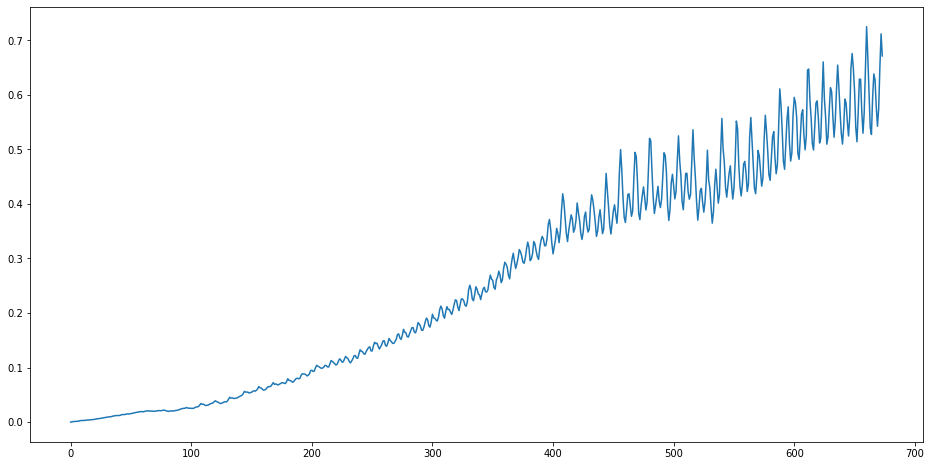

In [24]:
plt.figure(figsize=(16,8))
plt.plot(train)

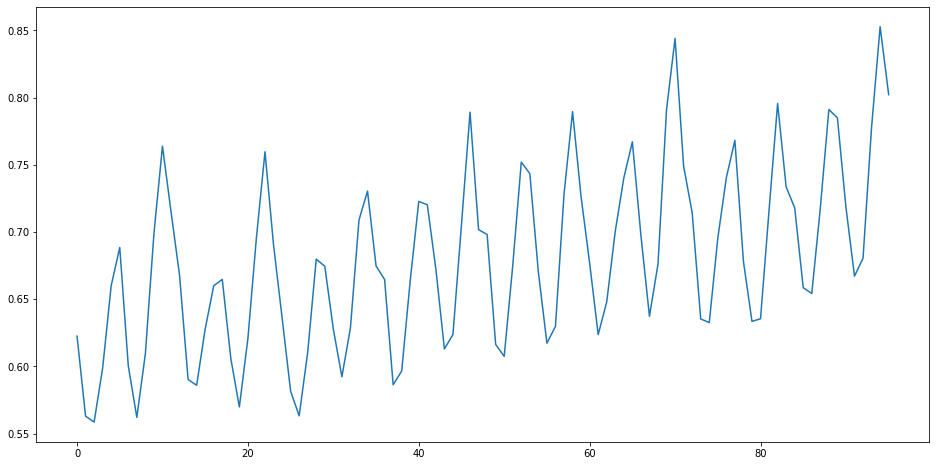

In [25]:
plt.figure(figsize=(16,8))
plt.plot(validation)

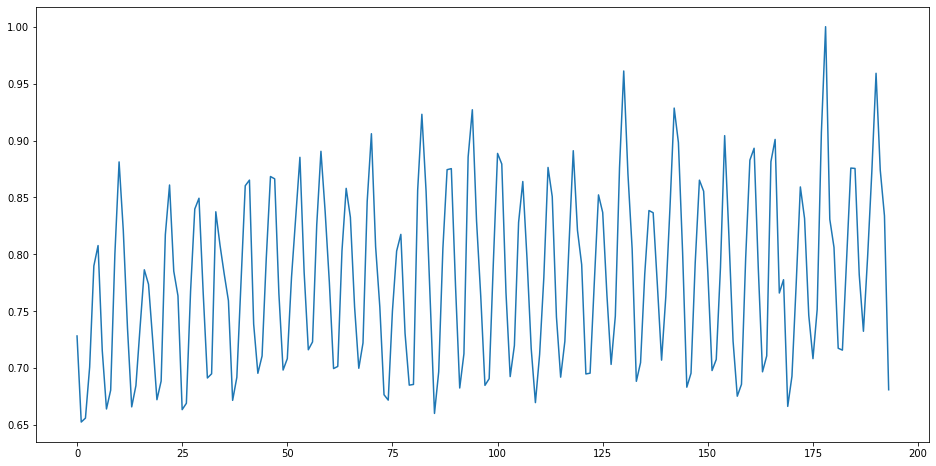

In [26]:
plt.figure(figsize=(16,8))
plt.plot(test)

In [40]:
# quantidade de atrasos
look_back = 5

X_train, y_train = create_dataset(train, look_back)
X_validation, y_validation = create_dataset(validation, look_back)
X_test, y_test = create_dataset(test, look_back)


In [42]:
X_train.shape

(668, 5)

In [43]:
# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [44]:
X_train.shape

(668, 5, 1)

In [48]:
X_train[0]

array([[0.        ],
       [0.00020554],
       [0.00082296],
       [0.0010285 ],
       [0.0010285 ]], dtype=float32)

In [49]:
y_train[0]

0.0014403742

In [50]:
X_train.shape

(668, 5, 1)

In [52]:
# Cria e treina a rede LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)

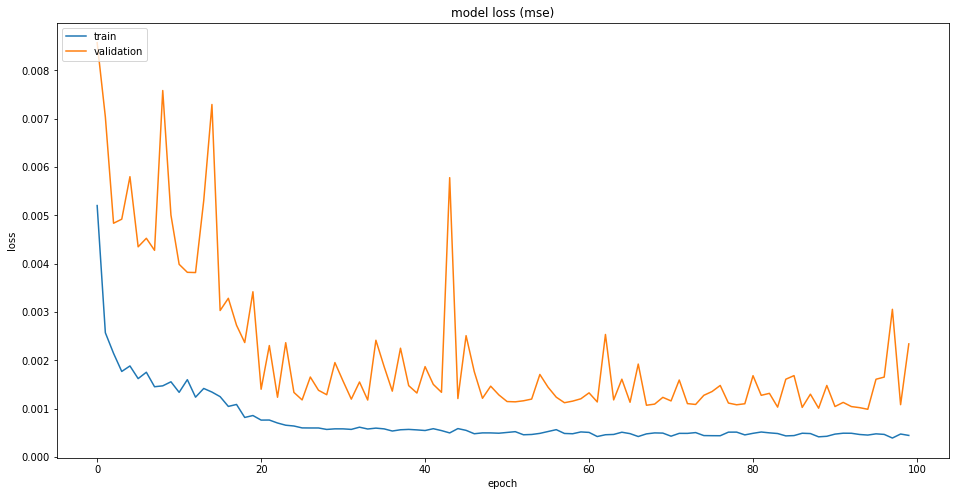

In [53]:
fig = plt.figure(figsize=(16,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (mse)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [54]:
# Predições
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [55]:
# Faz a transformação inversa das predições
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [56]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.23 RMSE
Test Score: 8.28 RMSE


In [59]:
len(trainPredict)

668

In [57]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [58]:
# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(X)-4, :] = testPredict

ValueError: could not broadcast input array from shape (188,1) into shape (282,1)

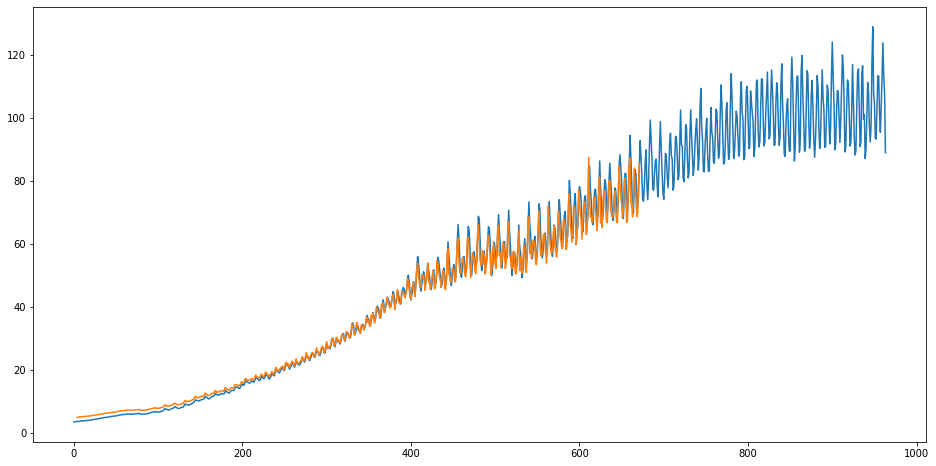

In [61]:
# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(X))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()